# Making Error Plot for Flow Past Disk Problem

### Import Stuff

In [1]:
import torch
import torch.nn as nn
import os
import sys
import numpy as np
import math
import scipy.special as bessel
from scipy.io import loadmat

import DRLPDE_nn
import DRLPDE_param_solver
import DRLPDE_functions.DefineDomain
import DRLPDE_functions.EvaluateWalkers

import matplotlib.pyplot as plt
import cv2

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

### Define Variables

In [2]:
### Domain_Size is 'Large' 'Medium' 'Small'

Domain_Size = 'Medium'

imagefilename = 'Error_Plot_' + 'JCPexample6'
imagesfolder = "images/"

### Domain Parameters
dim = 2

if Domain_Size == 'Large':
    L_right = 5.0
elif Domain_Size == 'Medium':
    L_right = 2.5
elif Domain_Size == 'Small':
    L_right = 1.0
    # Not Done

L_left = 0
L_height = L_right/5
R = L_height/3

circle_centre = [L_height,0]


######################## Plotting and Error Parameters ########################
numpts_x = 257
numpts_y =  129

x1g, x2g = torch.meshgrid([torch.linspace(L_left,L_right,numpts_x),
                              torch.linspace(-L_height,L_height,numpts_y)])

xg = torch.stack([x1g.reshape(-1), x2g.reshape(-1)], dim=-1).requires_grad_(True)

integral_factor = ((L_right - L_left)/(numpts_x-1))*((2*L_height)/(numpts_y-1))

x1plot = x1g.detach().cpu().numpy()
x2plot = x2g.detach().cpu().numpy()

###############################################################################
### Load the IBM model
Nx = 256 # Number of points along x-axis - Does not count end point
Ny = 160 # Number of points along y-axis - Does not count end point
N_channel = 128
num_files = 100

IBM_U = np.zeros((Ny,Nx))
IBM_V = np.zeros((Ny,Nx))


data = np.loadtxt('tools/vtk_files/Steady_Flow_Past_Disk_Medium_Re1.vtk')

data = data.reshape(-1).reshape((Nx*Ny,3))
IBM_U = data[:,0].reshape(Ny,Nx)
IBM_V = data[:,1].reshape(Ny,Nx)

IBM_U = IBM_U[16:N_channel + 16 + 1,:]
IBM_V = IBM_V[16:N_channel + 16 + 1,:]

IBM_U = np.concatenate( (IBM_U, IBM_U[:,0,None]), axis=1)
IBM_V = np.concatenate( (IBM_V, IBM_V[:,0,None]), axis=1)

### Prepare variables

L2_error_U = 0 
L2_error_V = 0

Linf_error_U = 0
Linf_error_V = 0

L2_norm_IBM_U = 0
L2_norm_IBM_V = 0

Linf_norm_IBM_U = np.amax(np.abs(IBM_U))
Linf_norm_IBM_V = np.amax(np.abs(IBM_V))

circle_plot = np.linspace(0,2*math.pi, 30)
x_circle = R*np.cos(circle_plot) + circle_centre[0]
y_circle = R*np.sin(circle_plot) + circle_centre[1]

C:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
loadmodel = 'JCPexample6'
model = torch.load("savedmodels/" + loadmodel + ".pt").to('cpu')

### Calculate Error

In [4]:
Trained_Vel = model(xg).reshape(numpts_x, numpts_y, 2).detach().numpy()
Trained_Vel_U = Trained_Vel[:,:,0]
Trained_Vel_V = Trained_Vel[:,:,1]    

### All the different Errors and norms ###

L2_error_U =  np.sum( ((Trained_Vel_U - np.transpose(IBM_U))**2 )*integral_factor)
L2_error_V =  np.sum( ((Trained_Vel_V - np.transpose(IBM_V))**2 )*integral_factor)

Linf_error_U = np.amax(np.abs(Trained_Vel_U - np.transpose(IBM_U)))
Linf_error_V = np.amax(np.abs(Trained_Vel_V - np.transpose(IBM_V)))

L2_norm_IBM_U = np.sum( (( np.transpose(IBM_U))**2)*integral_factor )
L2_norm_IBM_V = np.sum( (( np.transpose(IBM_V))**2)*integral_factor )
    
L2_error = np.sqrt( L2_error_U + L2_error_V )
Linf_error = np.amax( [Linf_error_U, Linf_error_V])

L2_norm_IBM = np.sqrt(L2_norm_IBM_U + L2_norm_IBM_V)
Linf_norm_IBM = np.amax( [np.amax( np.abs(IBM_U)), np.amax( np.abs(IBM_V))] )

print('L2_error = {:.5f}'.format(L2_error))
print('Linf_error = {:.5f}'.format(Linf_error))

print('Relative L2_error = {:.5f}'.format(L2_error/L2_norm_IBM))
print('Relative Linf_error = {:.5f}'.format(Linf_error/Linf_norm_IBM))


L2_error = 3.03358
Linf_error = 3.72510
Relative L2_error = 0.92487
Relative Linf_error = 0.92545


## Plot Some Contours

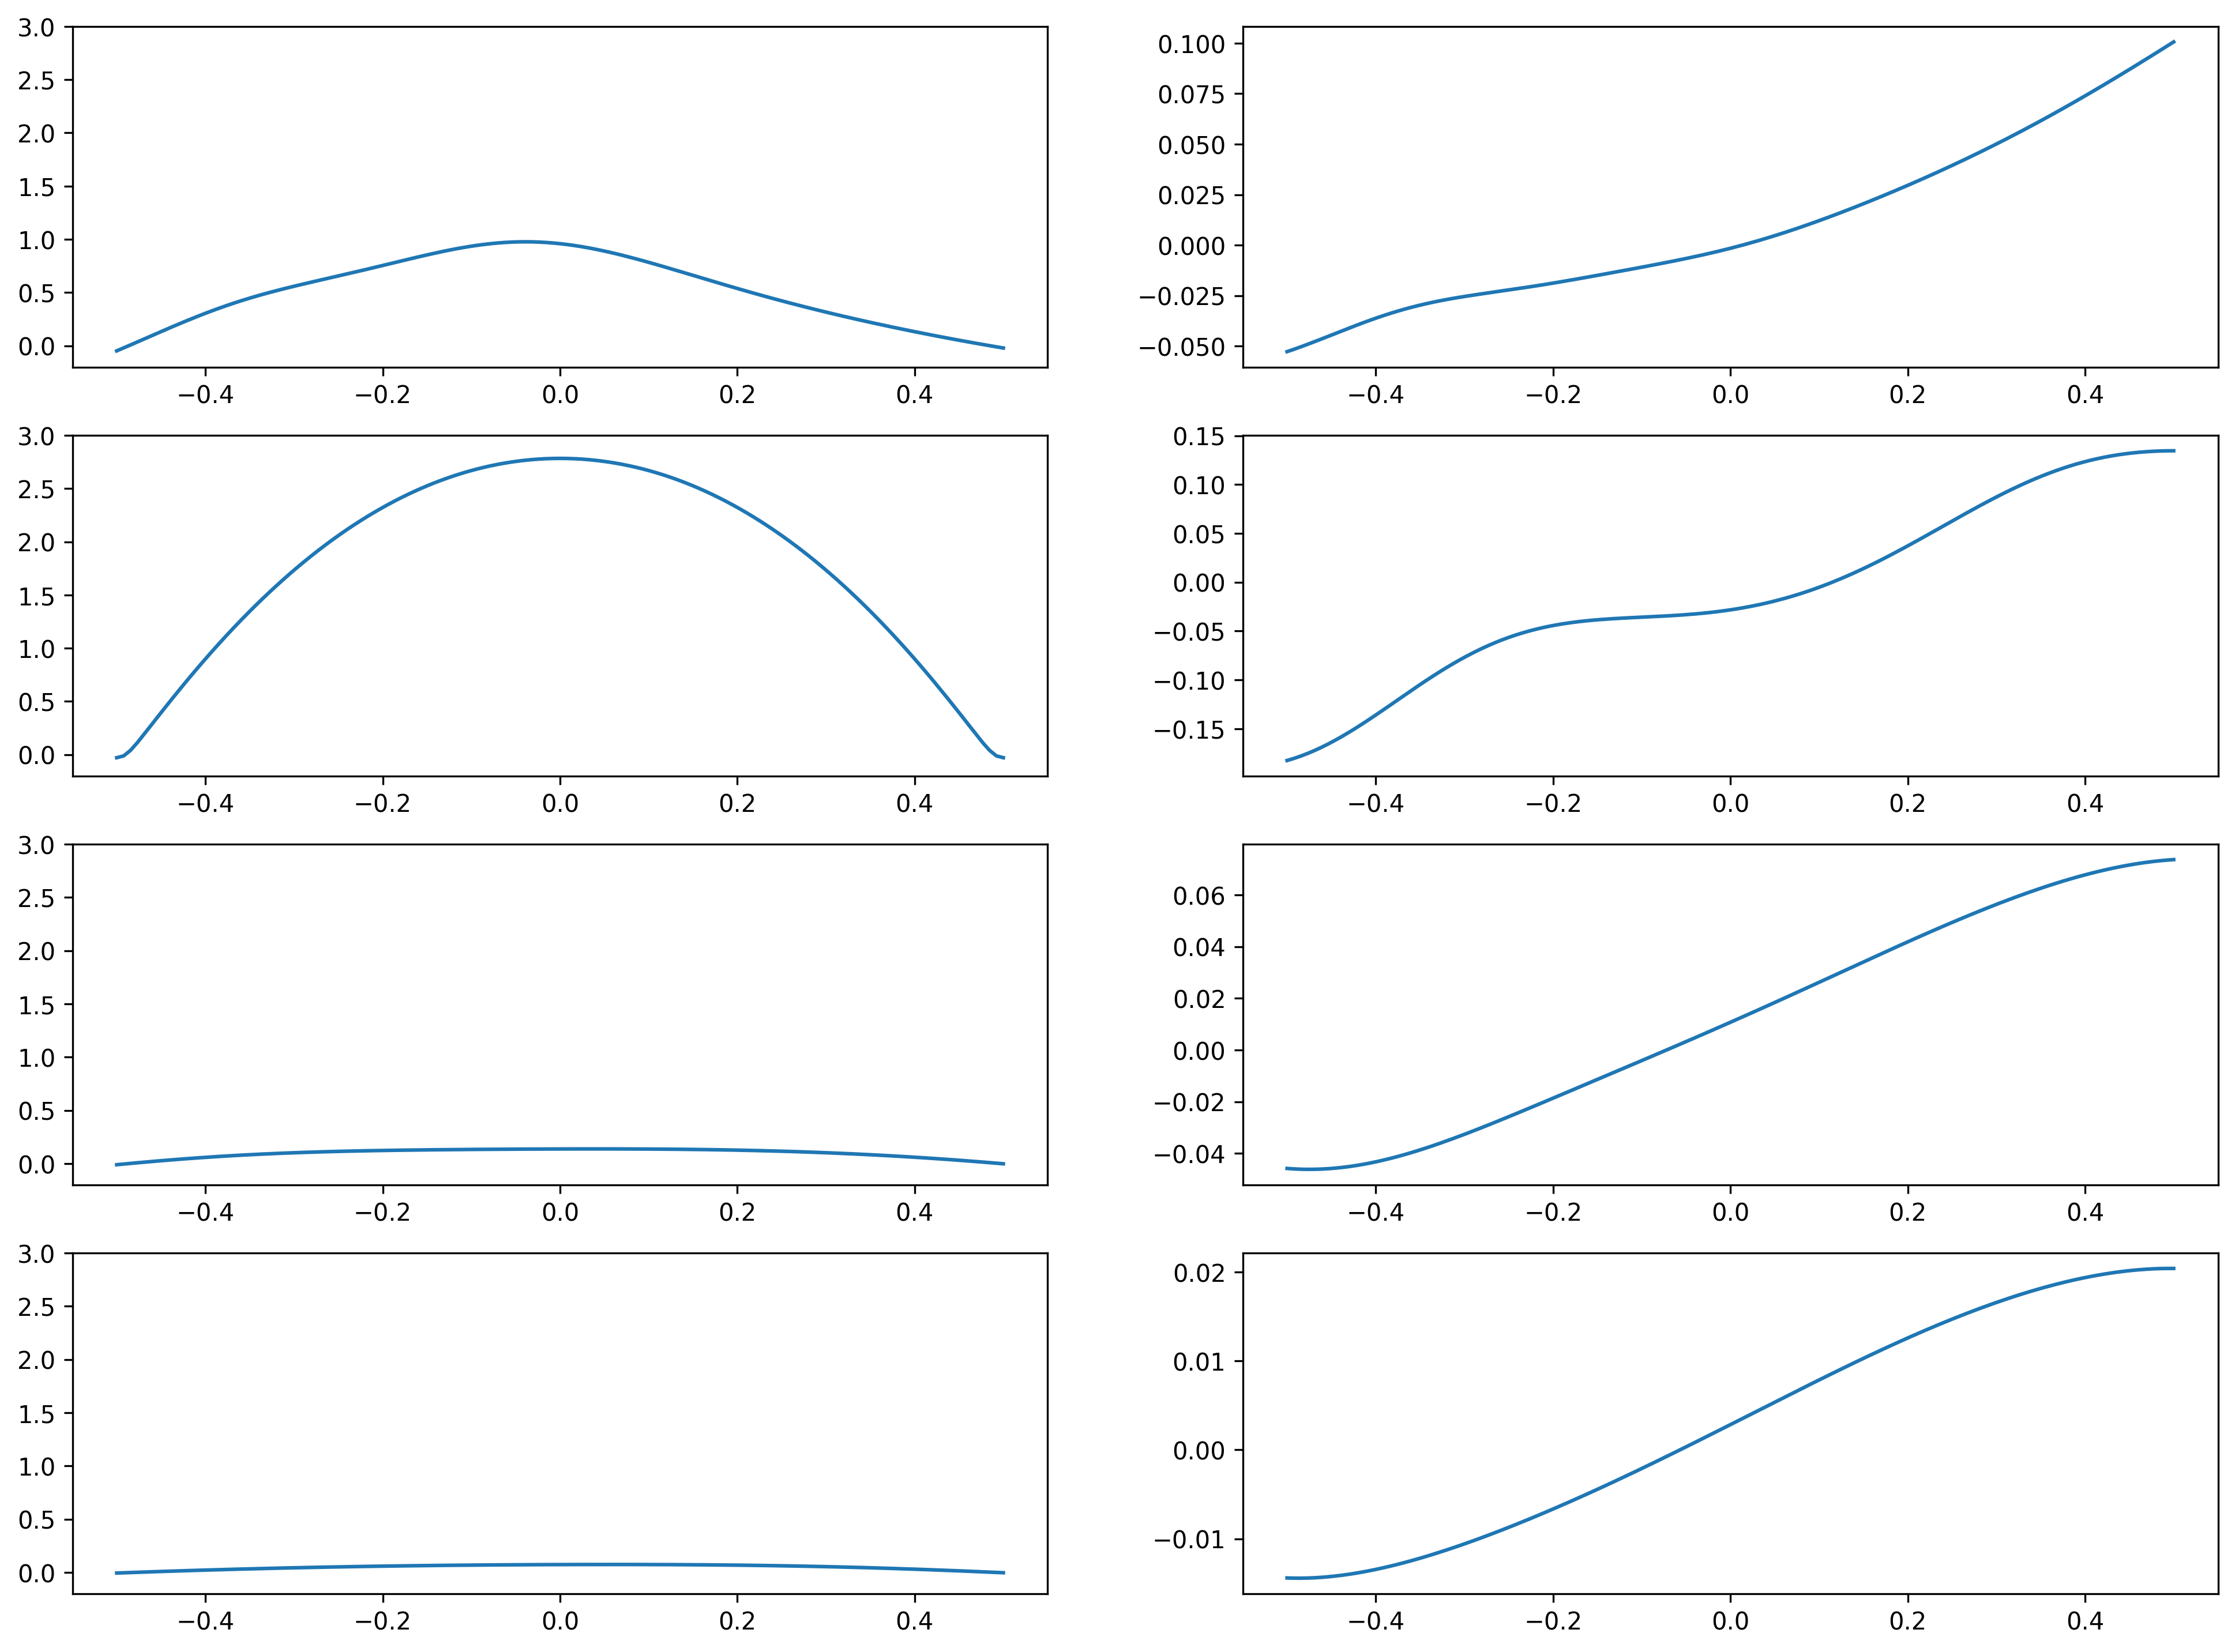

In [5]:
plt.close('all')
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(16, 12))

v0 = 12.0

#fig.suptitle('Comparison of Flow Past Disk', fontsize=20)
wall = np.linspace(-L_height, L_height, numpts_y)
true_vel= v0*(L_height - wall)*(L_height + wall)

ax[0,0].plot(wall, Trained_Vel_U[0,:])
ax[0,0].set_ylim(-0.2, v0*L_height**2)

ax[1,0].plot(wall, IBM_U[:,0])
ax[1,0].set_ylim(-0.2, v0*L_height**2)

ax[2,0].plot(wall, Trained_Vel_U[128,:])
ax[2,0].set_ylim(-0.2, v0*L_height**2)

ax[3,0].plot(wall, Trained_Vel_U[196,:])
ax[3,0].set_ylim(-0.2, v0*L_height**2)

ax[0,1].plot(wall, Trained_Vel_V[0,:])
#ax[0,1].set_ylim(-0.2, v0*L_height**2)

ax[1,1].plot(wall, Trained_Vel_V[64,:])
#ax[1,1].set_ylim(-0.2, v0*L_height**2)

ax[2,1].plot(wall, Trained_Vel_V[128,:])
#ax[2,1].set_ylim(-0.2, v0*L_height**2)

ax[3,1].plot(wall, Trained_Vel_V[196,:])
#ax[3,1].set_ylim(-0.2, v0*L_height**2)

### Plot Full

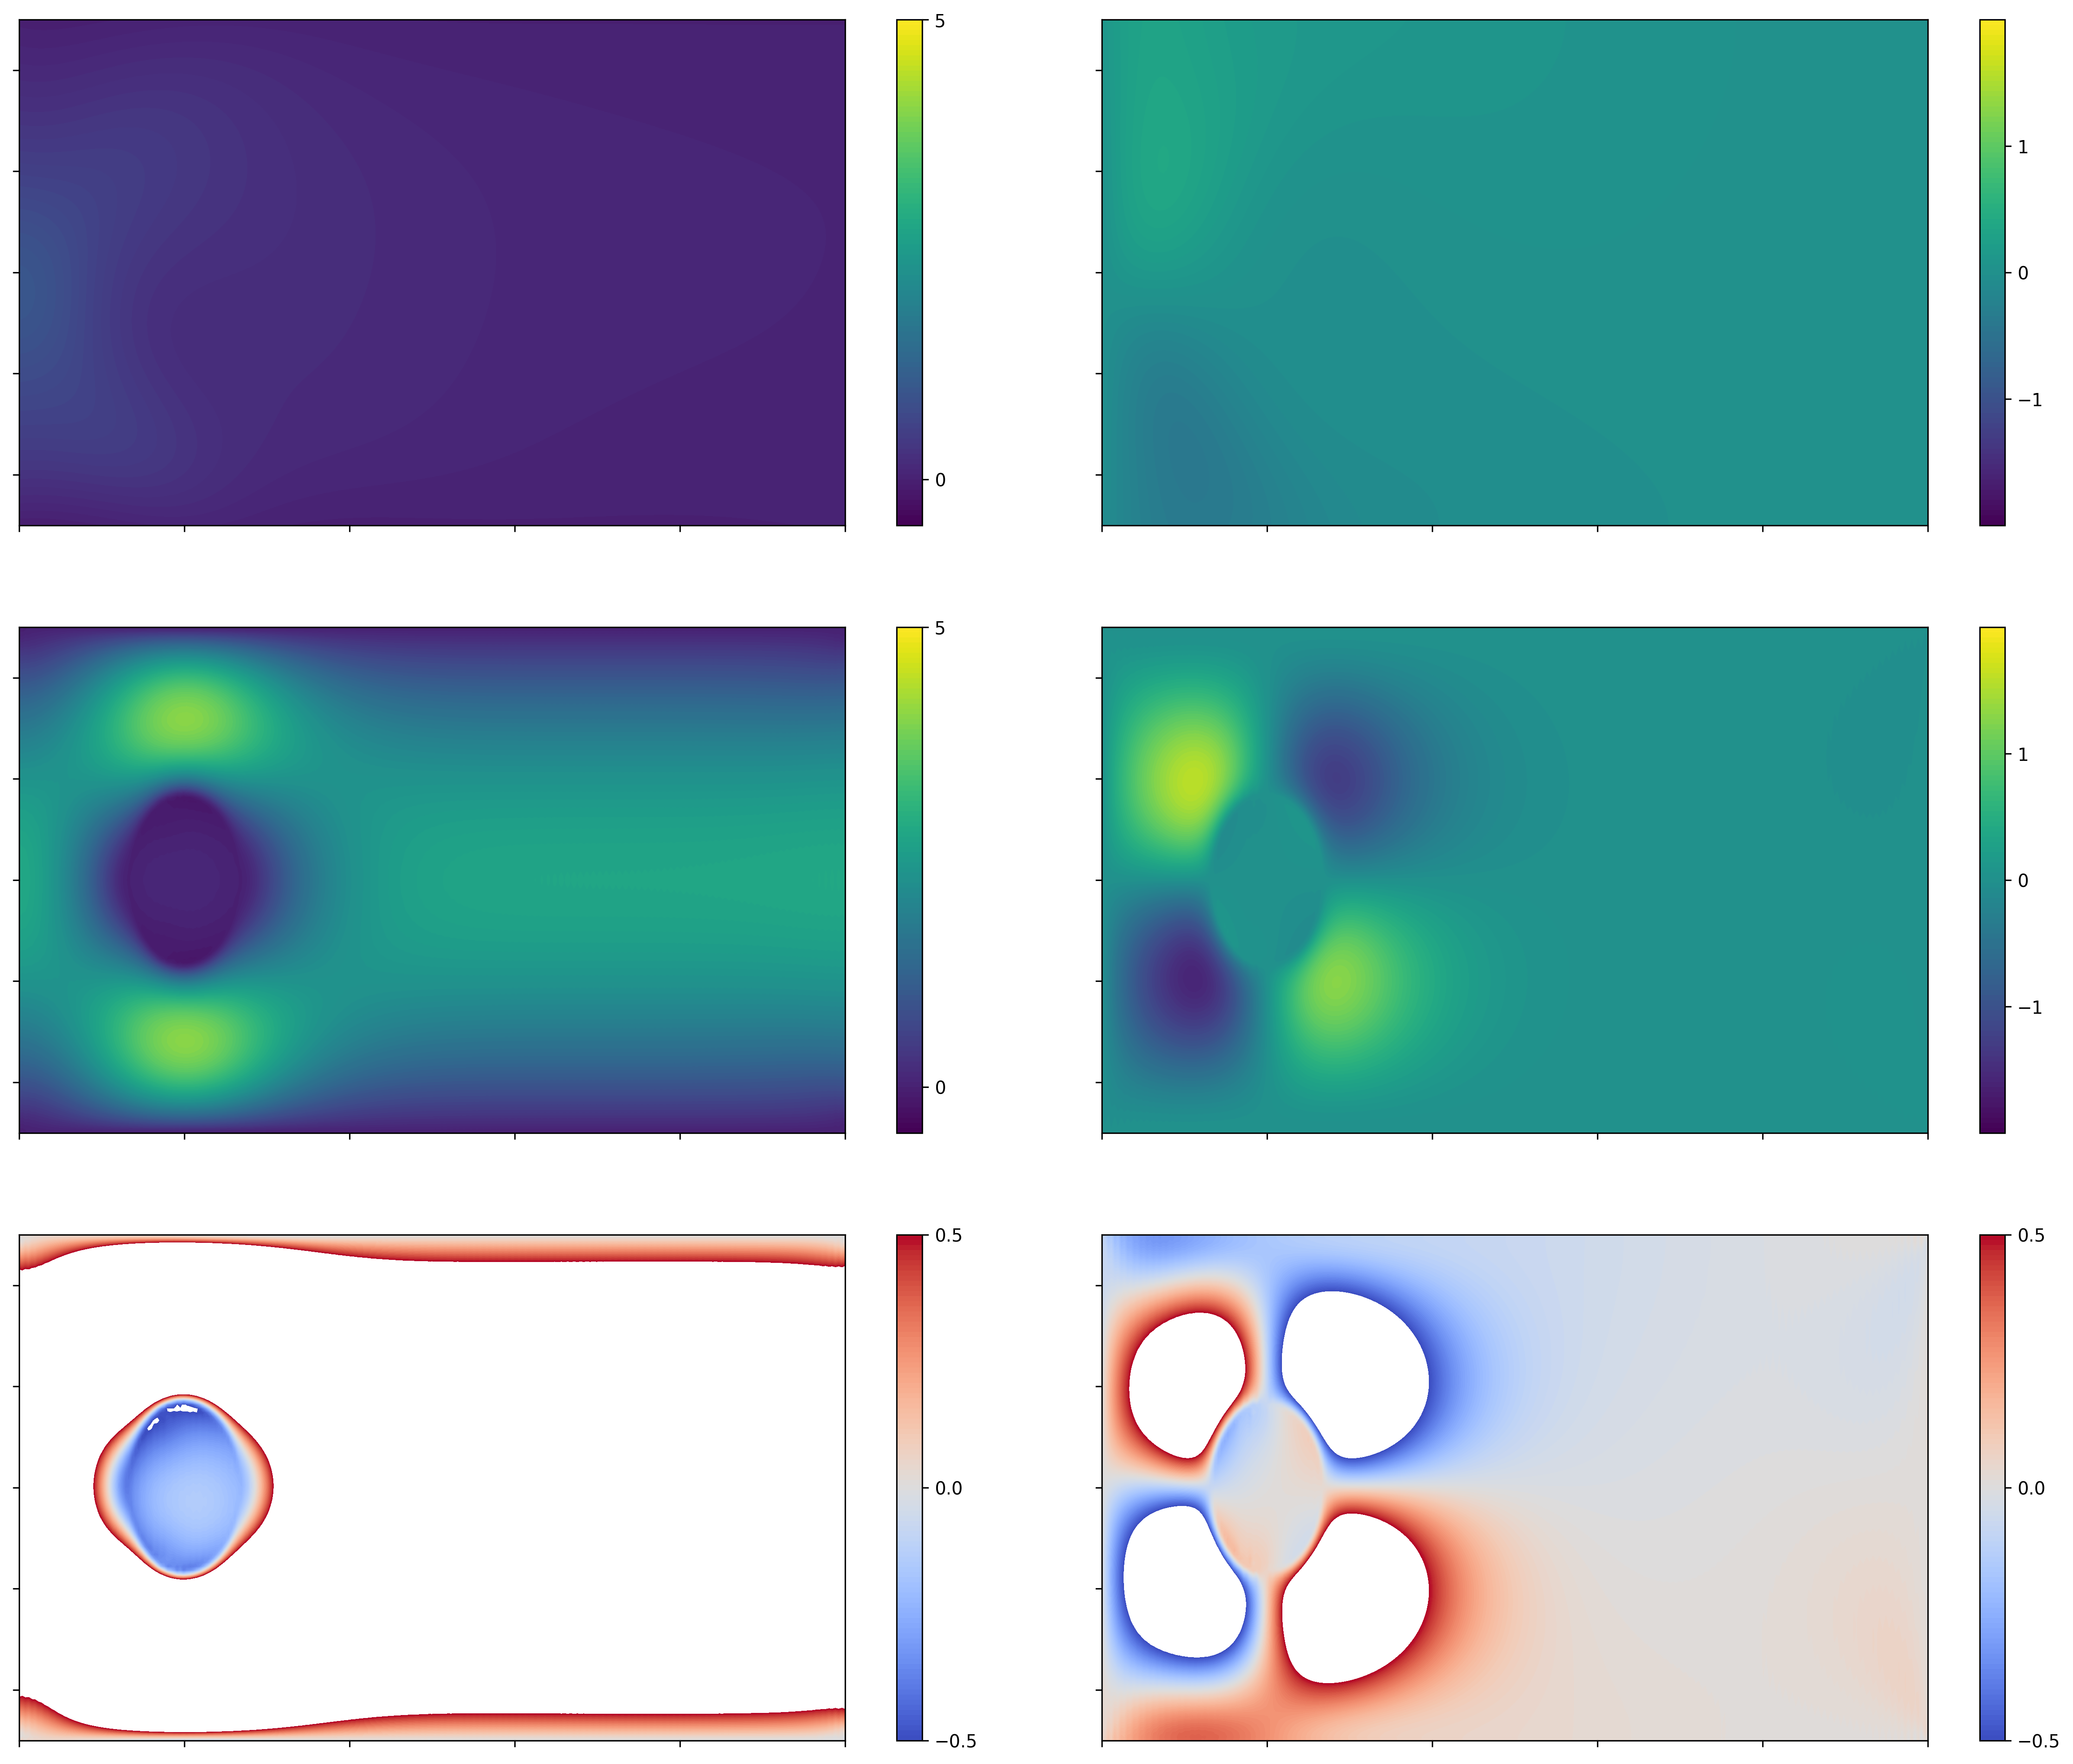

In [8]:
### Plotting
 
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

Trained_Vel = model(xg).reshape(numpts_x, numpts_y, 2).detach().numpy()

Trained_Vel_U = Trained_Vel[:,:,0]
u1_true = np.transpose(IBM_U)

Trained_Vel_V = Trained_Vel[:,:,1]
u2_true = np.transpose(IBM_V)

if Domain_Size == 'Large':

    levels_flow_1 = np.linspace(-0.5, 7.5, 100)
    levels_tick_1 = np.linspace(0, 7, 8)

    levels_flow_2 = np.linspace(-4, 4, 100)
    levels_tick_2 = [-4.0, -2.0, 0, 2.0, 4.0]

    error_levels = np.linspace(-3.0, 3.0, 100)
    error_tick = np.linspace(-3.0, 3.0 ,5)
    
elif Domain_Size == 'Medium':
    levels_flow_1 = np.linspace(-0.5, 5, 100)
    levels_tick_1 = np.linspace(0, 5, 2)

    levels_flow_2 = np.linspace(-2, 2, 100)
    levels_tick_2 = [-1, 0, 1]

    error_levels = np.linspace(-0.5, 0.5, 100)
    error_tick = np.linspace(-0.5, 0.5 ,3)


plt.close('all')
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18,15))

contour0 = ax[0,0].contourf(x1plot, x2plot, Trained_Vel_U, levels_flow_1, cmap=plt.cm.viridis)
#ax[0,0].set_title(r'Neural Network Approximation of $u_1$ velocity')
ax[0,0].set_xticklabels([])
ax[0,0].set_yticklabels([])
plt.colorbar(contour0, ticks =levels_tick_1, ax=ax[0,0])

contour1 = ax[1,0].contourf(x1plot, x2plot, u1_true, levels_flow_1, cmap=plt.cm.viridis)
#ax[1,0].set_title(r'IBM Solution of $u_1$')
ax[1,0].set_xticklabels([])
ax[1,0].set_yticklabels([])
plt.colorbar(contour1, ticks =levels_tick_1, ax=ax[1,0])

contour2 = ax[2,0].contourf(x1plot, x2plot, u1_true - Trained_Vel_U, levels=error_levels, cmap=plt.cm.coolwarm)
#ax[2,0].set_title(r'Difference between IBM and Neural Network of $u_1$')
ax[2,0].set_xticklabels([])
ax[2,0].set_yticklabels([])
plt.colorbar(contour2, ticks =error_tick, ax=ax[2,0])

contour3 = ax[0,1].contourf(x1plot, x2plot, Trained_Vel_V, levels_flow_2, cmap=plt.cm.viridis)
#ax[0,1].set_title(r'Neural Network Approximation of $u_2$ velocity')
ax[0,1].set_xticklabels([])
ax[0,1].set_yticklabels([])
plt.colorbar(contour3, ticks =levels_tick_2, ax=ax[0,1])

contour4 = ax[1,1].contourf(x1plot, x2plot, u2_true, levels_flow_2, cmap=plt.cm.viridis)
#ax[1,1].set_title(r'IBM Solution of $u_2$')
ax[1,1].set_xticklabels([])
ax[1,1].set_yticklabels([])
plt.colorbar(contour3, ticks =levels_tick_2, ax=ax[1,1])

contour5 = ax[2,1].contourf(x1plot, x2plot, u2_true - Trained_Vel_V, levels=error_levels, cmap=plt.cm.coolwarm)
#ax[2,1].set_title(r'Difference between IBM and Neural Network of $u_2$')
ax[2,1].set_xticklabels([])
ax[2,1].set_yticklabels([])
plt.colorbar(contour5, ticks =error_tick, ax=ax[2,1])

plt.tight_layout(pad=5.0)

#fig.savefig('images/JCPexample6', facecolor='w', transparent=False)